# VC Project 2

## Imports

In [176]:
import cv2
import numpy as np
np.random.seed(42)
import ast
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from mnist import MNIST
import warnings
from IPython.display import display, Image
import os
import json
import sys
import torch
from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

# ======================== Suppress Warnings ========================

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [177]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Defining functions

In [178]:
def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names

def loadImage(num, imgLoadSizeRatio = 1, dataDir = 'data/imgs', standardSize = -1):
    img = cv2.imread(os.path.join(dataDir, f'{num}'))
    if standardSize > 0:
        img = cv2.resize(img, (standardSize, standardSize))
    elif imgLoadSizeRatio != 1:
        img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img

def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.png', image)[1].tobytes()
    display(Image(data=img_bytes))

df_lego_sets = pd.read_csv("data/values.csv")

def getActualPieceCount(imgID):
    global df_lego_sets
    piece_count = df_lego_sets.loc[df_lego_sets['id'] == imgID, 'lego_count'].values[0]
    return piece_count 

def getBoundingBoxes(name):
    global df_lego_sets
    bb_list_str = df_lego_sets.loc[df_lego_sets['id'] == name, 'bb_list'].values[0]
    bb_list = ast.literal_eval(bb_list_str)
    return bb_list

def makeGuess(image_id, num_guess):
    piece_count = getActualPieceCount(image_id)
    num_legos_error = abs(num_guess - piece_count)
    
    if(num_legos_error > 0):
        print(f"Error in Lego Count - Guessed: {num_guess} | Actual: {piece_count} legos")
    else :
        print(f"Perfect ({num_guess}) Guess!")
        
    return piece_count, num_legos_error


## Loading the data

In [179]:
imgs = []

img_names = get_file_names('data/imgs')

for name in img_names:
    img = loadImage(name)
    count = getActualPieceCount(name[:-4])
    bbs = getBoundingBoxes(name[:-4])
    imgs.append((img, count, bbs))

    if (count < 2):
        continue
    # apply multiple transformations to the image to upsample the dataset
    # Rotation
    rotated_image_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    imgs.append((rotated_image_90, count))
    
    rotated_image_180 = cv2.rotate(img, cv2.ROTATE_180)
    imgs.append((rotated_image_180, count))
    
    rotated_image_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgs.append((rotated_image_270, count))
    
    # Flipping
    flipped_image = cv2.flip(img, flipCode=1)
    imgs.append((flipped_image, count))
    
    flipped_image = cv2.flip(img, flipCode=0)
    imgs.append((flipped_image, count))
    
    # Rotation + Flipping
    rotated_flipped_image = cv2.flip(rotated_image_90, flipCode=1)
    imgs.append((rotated_flipped_image, count))

# From the images that have just 1 lego, remove half of them
ones_imgs = [img for img in imgs if img[1] == 1]
np.random.shuffle(ones_imgs)
ones_imgs = ones_imgs[:int(len(ones_imgs)/2)]
imgs = [img for img in imgs if img[1] != 1]
imgs.extend(ones_imgs)

# Display the balance of the dataset
lego_counts = [img[1] for img in imgs]
lego_counts = Counter(lego_counts)
print(lego_counts)

# suffle the images
np.random.shuffle(imgs)    

# Size of dataset that we will be using:
datasetSize = 1000

"""
# If we want to keep them stratified
# Sample the images and make sure they are stratified
X = [img[0] for img in imgs]
y = [img[1] for img in imgs]

X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=len(X)-200, stratify=y, random_state=42)
sampled_imgs = [(X_sampled[i], y_sampled[i]) for i in range(len(X_sampled))]
# pick the first 70% of the images for training 
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.30, stratify=y_sampled, random_state=42)

# and pick the remaining 15% of the images for validation and 15% for testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Combine the images and their counts
train_imgs = [(X_train[i], y_train[i]) for i in range(len(X_train))]
val_imgs = [(X_val[i], y_val[i]) for i in range(len(X_val))]
test_imgs = [(X_test[i], y_test[i]) for i in range(len(X_test))]

# pick the first 70% of the images for training
train_imgs = sampled_imgs[:int(datasetSize * 0.7)]
val_imgs = sampled_imgs[int(datasetSize * 0.7):int(datasetSize * 0.85)]
test_imgs = sampled_imgs[int(datasetSize * 0.85):]
"""

imgs = imgs[:datasetSize]
    
# pick the first 70% of the images for training
train_imgs = imgs[:int(len(imgs)*0.7)]

# pick the remaining 15% of the images for validation and the last 15% for testing
val_imgs = imgs[int(len(imgs)*0.7):int(len(imgs)*0.85)]
test_imgs = imgs[int(len(imgs)*0.85):]

print(len(train_imgs))
print(len(val_imgs))
print(len(test_imgs))

# Calculate the distribution of the number of legos in each set
train_lego_counts = [img[1] for img in train_imgs]
val_lego_counts = [img[1] for img in val_imgs]
test_lego_counts = [img[1] for img in test_imgs]

train_lego_counts = Counter(train_lego_counts)
val_lego_counts = Counter(val_lego_counts)
test_lego_counts = Counter(test_lego_counts)

print(train_lego_counts)
print(val_lego_counts)
print(test_lego_counts)

Counter({1: 2650, 2: 2338, 3: 434, 4: 280, 5: 126, 8: 70, 7: 56, 10: 49, 9: 49, 18: 49, 6: 42, 11: 35, 14: 35, 15: 35, 30: 28, 27: 28, 32: 21, 12: 21, 24: 14, 17: 14, 31: 7, 16: 7, 23: 7, 28: 7, 26: 7, 29: 7, 20: 7, 25: 7, 13: 7})
700
150
150
Counter({1: 295, 2: 235, 3: 48, 4: 33, 5: 12, 8: 10, 18: 6, 7: 6, 32: 6, 27: 6, 11: 6, 9: 5, 6: 5, 15: 4, 31: 3, 30: 3, 10: 3, 14: 3, 12: 3, 20: 2, 29: 2, 25: 1, 16: 1, 13: 1, 28: 1})
Counter({2: 59, 1: 56, 3: 10, 4: 10, 15: 3, 5: 3, 8: 2, 17: 2, 6: 2, 30: 1, 24: 1, 14: 1})
Counter({2: 60, 1: 58, 3: 8, 4: 5, 7: 3, 5: 3, 8: 2, 30: 2, 9: 1, 13: 1, 10: 1, 23: 1, 12: 1, 14: 1, 32: 1, 11: 1, 17: 1})


## Defining the model

In [180]:
class CustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]

      # Apply transformations to the image
      if self.transform:
        image = self.transform(image)

      label = int(self.labels[idx])
      return (image, label)

In [181]:
train_images = [img[0] for img in train_imgs]
train_labels = [img[1] for img in train_imgs]
val_images = [img[0] for img in val_imgs]
val_labels = [img[1] for img in val_imgs]
test_images = [img[0] for img in test_imgs]
test_labels = [img[1] for img in test_imgs]

batch_size = 32 # how many images are processed at a time
num_workers = 4 # how many processes are used to load the data

# Define transformations
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset objects
training_data = CustomDataset(train_images, train_labels, transform=data_aug)
validation_data = CustomDataset(val_images, val_labels, transform=data_aug)
testing_data = CustomDataset(test_images, test_labels, transform=data_aug)

# Define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Show one image
# plt.imshow(training_data[0][0][0,:,:], cmap='gray')

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

22
5
5
Using cpu device


In [182]:

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Conv2d(self.nb_filters, self.nb_filters * 2, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters * 2, self.nb_filters * 2, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(179776, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 33)  # we have 33 classes to guess
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=179776, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=512, out_features=33, bias=True)
  )
)


## Train

In [183]:
# Create folder to save the models
try:
    folder_name = "models-temp"
    os.mkdir(folder_name)
except FileExistsError:
    pass

In [184]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True, preds=[], labels=[]):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)
    
    if num_batches == 0:
      print("No data in the dataloader")
      return 0.0, 0.0

    if is_train:
      model.train()
    else:
      model.eval()

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Obtain prediction
          pred = model(X)
          
          # Obtain loss value
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Calculate final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [185]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  
  best_val_loss = np.inf
  
  print("Start training...")
  
  for t in range(num_epochs):
    
      print(f"\nEpoch {t+1}")
      
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      
      if(train_acc > 0):
        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      else :
        val_loss = 0
        val_acc = 0
        
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, "models/" + model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, "models/" + model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [186]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [187]:
num_epochs = 1
model_name = 'custom_CNN'

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(model.parameters(), lr=0.01)

custom_train_history, custom_val_history = train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

Start training...

Epoch 1


 36%|███▋      | 8/22 [00:35<01:02,  4.48s/it]


KeyboardInterrupt: 

## Testing

In [ ]:
# Display the confusion matrix exactly as received from the sklearn library
def display_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(12, 12))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # We will have at most 33 classes
    plt.xticks(range(0, 32))
    plt.yticks(range(0, 32))
    # The padding should be set to 0
    plt.gca().set_xticklabels([str(x) for x in range(1, 33)])
    plt.gca().set_yticklabels([str(x) for x in range(1, 33)])
    plt.show()

def buildConfusionMatrix(preds, labels):
    # We will build our custom confusion matrix with 32 classes
    confusion_matrix = np.zeros((32, 32))
    for i in range(len(preds)):
        confusion_matrix[labels[i]-1, preds[i]-1] += 1
    return confusion_matrix

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



Test Loss: 0.487 
Test Accuracy: 0.903

[[271.   0.   0. ...   0.   0.   0.]
 [ 17.   0.   0. ...   0.   0.   0.]
 [  6.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


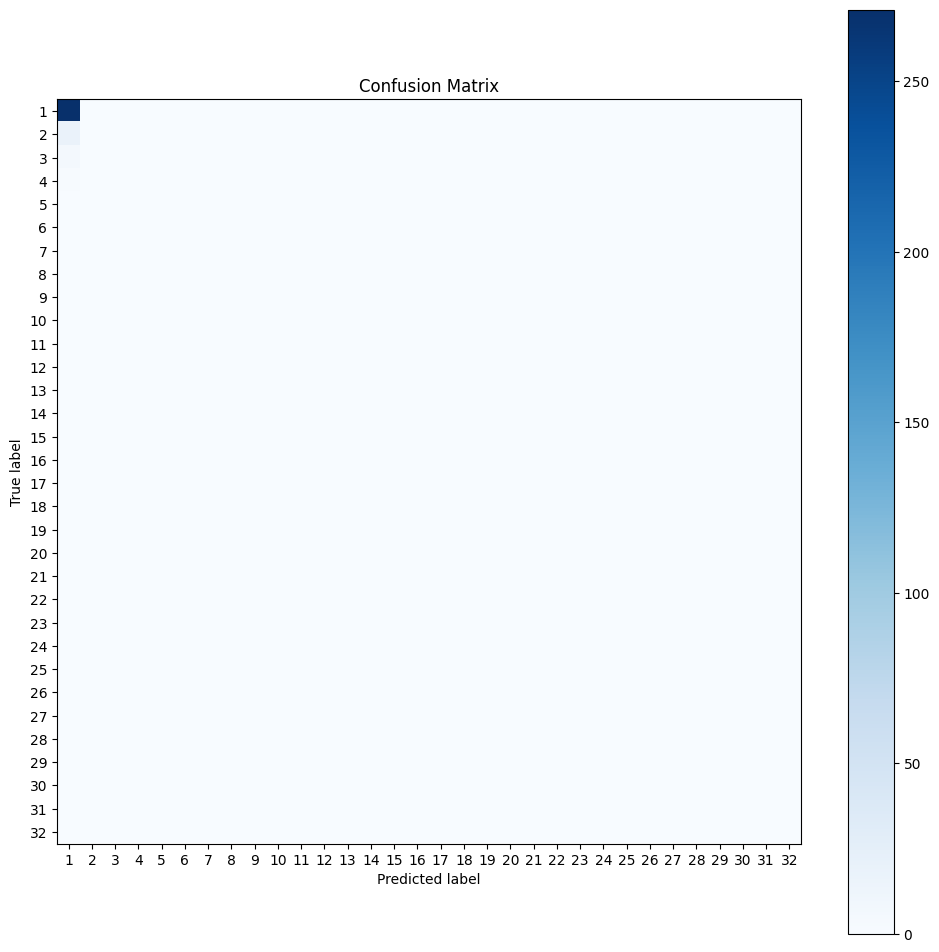

In [ ]:
# Load model
model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load("models/" + model_name + '_best_model.pth')
model.load_state_dict(checkpoint['model'])

# Test model
preds = []
labels = []
test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False, preds=preds, labels=labels)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}\n")

# Confusion matrix with the number in each cell
confusion_matrix = buildConfusionMatrix(preds, labels)
print(confusion_matrix)
# Display confusion matrix
display_confusion_matrix(confusion_matrix)


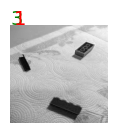

In [96]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= num_examples: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
      
    plt.show()
    
showErrors(model, test_dataloader)

## Pre-trained model

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.9/models.html)


In [ ]:
vgg = models.vgg16(pretrained=True)
vgg.to(device)

# set out_features of the last layer to 33
vgg.classifier[6] = nn.Linear(4096, 33)

print(vgg)

# Train network for 10 epochs
num_epochs = 1
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=0.01)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)